# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

**Carregando os dados**

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path
import statsmodels.formula.api as smf

from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
# Faz a leitura dos dados pelo link e grava em um arquivo
# Se o arquivo com os dados já existe, lê os dados do arquivo

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
path = 'processed.cleveland.csv'

if os.path.isfile(path):
    df = pd.read_csv(path)
else:
    cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg','thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
    df = pd.read_csv(url, names=cols)
    df.to_csv(path, index=False)


In [3]:
# cria a coluna "doente"
# o indivíduo está doente se o valor da coluna "num" é diferente de 0
# num: diagnóstico de doença cardíaga (status de doença angiográfica)

df['doente'] = (df['num'] != 0).astype('int64')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


<br>

**Analise das variáveis**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
 14  doente    303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


- **Variável ca**

In [6]:
# Variável ca (número de vasos principais (0-3) coloridos por fluorosopia) é do tipo object
# Verificando os valores distintos dessa variável

df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [7]:
# Filtrando os registros com ?

df[df['ca'] == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,doente
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0,0


In [8]:
# Registros cujo valor da coluna ca sejam iguais a '?' serão apagados

df.drop(df[df['ca'] == '?'].index, inplace=True)

- **Variável thal**

In [9]:
# Variável thal (3 = normal; 6 = defeito corrigido; 7 = defeito reversível) é do tipo object
# Verificando os valores distintos dessa variável

df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [10]:
# Filtrando os registros com ?

df[df['thal'] == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,doente
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0,0
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2,1


In [11]:
# Registros cujo valor da coluna thal sejam iguais a '?' serão apagados

df.drop(df[df['thal'] == '?'].index, inplace=True)

- **Variáveis tipo int**

In [12]:
# As variáveis age, sex, cp, trestbps, fbs, restecg, exang, slope, ca e thal podem ser convertidas para o tipo int

# primeiro convertemos as variáveis ca e thal para float
df = df.astype({'ca': 'float64', 'thal': 'float64'})

# convertemos as variáveis age, sex, cp, trestbps, fbs, restecg, exang, slope, ca e thal para int
mapping = {}
for coluna in ['age', 'sex', 'cp', 'trestbps', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']:
    mapping[coluna] = 'int64'
    
df = df.astype(mapping)

<br>

**Exercício**

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. \
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [13]:
# Função para criar um Dataframe para uma análise bivariada

def df_bivariada(dados: pd.DataFrame, resposta: str, explicativa: str) -> pd.DataFrame:
    
    # cria um Dataframe crosstab
    data = pd.crosstab(dados[explicativa], dados[resposta], margins=True)
    
    # Percentual da variável resposta sobre a possibilidade de evento = 1
    data[f'percentual_{resposta}'] = data[1] / data['All']
    
    # Odds
    data['odds'] = data[1] / data[0]
    
    # Odds ratio (Usa o total como referência)
    data['odds_ratio'] = data[1] / data.loc['All', 1]
    
    # Logito (LOG(Odds))
    data['logito'] = np.log(data['odds'])
    
    # O LOG do Odds ratio (com o total como referência)
    data['log_odds_ratio'] = np.log(data['odds_ratio'])
    
    return data

- **Bivariada para a variável sex**

In [14]:
df_bivariada(df, 'doente', 'sex')

doente,0,1,All,percentual_doente,odds,odds_ratio,logito,log_odds_ratio
sex,,,,,,,,
0,71,25,96,0.260417,0.352113,0.182482,-1.043804,-1.701105
1,89,112,201,0.557214,1.258427,0.817518,0.229863,-0.201482
All,160,137,297,0.461279,0.856250,1.000000,-0.155193,0.000000


- **Bivariada para a variável cp: tipo de dor no peito**

In [15]:
df_bivariada(df, 'doente', 'cp')

doente,0,1,All,percentual_doente,odds,odds_ratio,logito,log_odds_ratio
cp,,,,,,,,
1,16,7,23,0.304348,0.437500,0.051095,-0.826679,-2.974071
2,40,9,49,0.183673,0.225000,0.065693,-1.491655,-2.722756
3,65,18,83,0.216867,0.276923,0.131387,-1.284016,-2.029609
4,39,103,142,0.725352,2.641026,0.751825,0.971167,-0.285252
All,160,137,297,0.461279,0.856250,1.000000,-0.155193,0.000000


- **Bivariada para a variável restecg: resultados eletrocardiográficos em repouso**

In [16]:
df_bivariada(df, 'doente', 'restecg')

doente,0,1,All,percentual_doente,odds,odds_ratio,logito,log_odds_ratio
restecg,,,,,,,,
0,92,55,147,0.374150,0.597826,0.401460,-0.514455,-0.912648
1,1,3,4,0.750000,3.000000,0.021898,1.098612,-3.821369
2,67,79,146,0.541096,1.179104,0.576642,0.164755,-0.550533
All,160,137,297,0.461279,0.856250,1.000000,-0.155193,0.000000


- **Qual delas parece discriminar mais o risco?**

Das três variáveis selecionadas a que parece discriminar mais o risco é a variável cp: tipo de dor no peito

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [17]:
# função semelhante para categorizar variáveis quantitativas contínuas

def df_bivariada_categoria(dados: pd.DataFrame, resposta: str, explicativa: str, qtd_categoria: int = 5) -> pd.DataFrame:
    
    # faz uma cópia do Dataframe
    copia = dados.copy()
    
    # nome para uma nova variável que irá receber o valor da categoria
    nome_variavel = f'{explicativa}_cat'
    
    # categoriza os dados e atribui a nova variável
    copia[nome_variavel] = pd.qcut(copia[explicativa], qtd_categoria)
    
    # chama a função criada anteriormente para criar a bivariada
    return df_bivariada(copia, resposta, nome_variavel)

In [18]:
# cria uma bivariada para a variável age com 5 grupos (valor default)

df_bivariada_categoria(df, 'doente', 'age')

doente,0,1,All,percentual_doente,odds,odds_ratio,logito,log_odds_ratio
age_cat,,,,,,,,
"(28.999, 45.0]",46,15,61,0.245902,0.326087,0.109489,-1.120591,-2.211931
"(45.0, 53.0]",40,21,61,0.344262,0.525000,0.153285,-0.644357,-1.875458
"(53.0, 58.0]",31,39,70,0.557143,1.258065,0.284672,0.229574,-1.256419
"(58.0, 62.8]",13,32,45,0.711111,2.461538,0.233577,0.900787,-1.454245
"(62.8, 77.0]",30,30,60,0.500000,1.000000,0.218978,0.000000,-1.518784
All,160,137,297,0.461279,0.856250,1.000000,-0.155193,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [19]:
reg = smf.logit("doente ~ C(sex) + C(cp) + trestbps + age", data=df).fit()
reg.summary()

Optimization terminated successfully.
         Current function value: 0.480667
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                            6
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.3035
Time:                        22:37:28   Log-Likelihood:                -142.76
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 1.910e-24
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -8.3249      1.617     -5.149      0.000     -11.494      -5.156
C(sex)[T.1]     1.7989      0.352      5.112      0.000       1.109       2.489
C(cp)[T.2]     -0.0167      0.638     -0.026      0.979      -1.267       1.233
C(cp)[T.3]      0.1132      0.574      0.197      0.844      -1.011       1.238
C(cp)[T.4]      2.4547      0.553      4.443      0.000       1.372       3.538
trestbps        0.0192      0.009      2.255      0.024       0.003       0.036
age             0.0568      0.018      3.110      0.002       0.021       0.093
===============================================================================
"""

**Interpretação dos parâmetros:**

Todas as variáveis testadas se mostraram estatisticamente relevantes, exceto a variável cp, que apresentou um p-value maior do que 5%. Talvez com a inclusão de outras variáveis no modelo essa varia possa ser estatisticamente relevante.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [20]:
# Calcule a probabilidade de evento predita segundo o seu modelo

df['predito'] = reg.predict(df)

In [21]:
# Categorize essa probabilidade em G=5 grupos

df['cat_pred'] = pd.qcut(df['predito'], 5)

In [22]:
# Calcule a probabilidade de evento predita média por grupo

grupos = df.groupby('cat_pred')
cat_pred = grupos[['predito']].mean()
cat_pred

,predito
cat_pred,
"(0.0139, 0.149]",0.075238
"(0.149, 0.29]",0.216382
"(0.29, 0.583]",0.440109
"(0.583, 0.819]",0.707344
"(0.819, 0.943]",0.874928


In [23]:
# Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo

cat_pred['doente'] = grupos['doente'].mean()
cat_pred

,predito,doente
cat_pred,,
"(0.0139, 0.149]",0.075238,0.081967
"(0.149, 0.29]",0.216382,0.155172
"(0.29, 0.583]",0.440109,0.508475
"(0.583, 0.819]",0.707344,0.737705
"(0.819, 0.943]",0.874928,0.827586


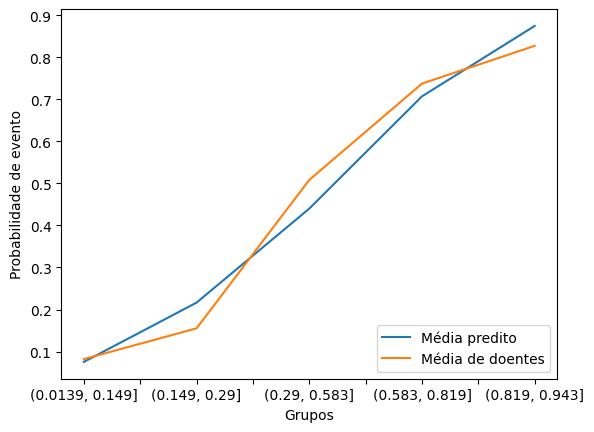

In [24]:
# Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = cat_pred['predito'].plot(label='Média predito')
ax = cat_pred['doente'].plot(label='Média de doentes')

ax.legend(loc='lower right')
ax.set_ylabel('Probabilidade de evento')
_ = ax.set_xlabel('Grupos')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [44]:
def avaliar_modelo():
    # accuracy_score: y_true, y_pred
    acc = metrics.accuracy_score(df['doente'], (df['predito'] > 0.5))
    acc = acc * 100

    # roc_curve: y_true, y_score
    fpr, tpr, thresholds = metrics.roc_curve(df['doente'], df['predito'])

    # Area Under the Curve
    auc = metrics.auc(fpr, tpr)

    # gini
    gini = 2 * auc - 1
    gini = gini * 100

    # KS
    ks = ks_2samp(df.loc[df['doente'] == 1, 'predito'], df.loc[df['doente'] != 1, 'predito']).statistic
    ks = ks * 100
    
    print(f'Acurácia: {acc:0.2f}%')
    print(f'GINI: {gini:0.2f}%')
    print(f'KS: {ks:0.2f}%')

In [45]:
avaliar_modelo()

Acurácia: 79.12%
GINI: 69.74%
KS: 58.52%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [59]:
reg = smf.logit("doente ~ C(sex) + trestbps + chol + C(fbs) + thalach + C(exang) + C(slope) + C(ca)", data=df).fit()
reg.summary()

Optimization terminated successfully.
         Current function value: 0.378511
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                           11
Date:                Sun, 01 Oct 2023   Pseudo R-squ.:                  0.4515
Time:                        00:46:59   Log-Likelihood:                -112.42
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 9.015e-34
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.7510      2.151     -2.209      0.027      -8.967      -0.535
C(sex)[T.1]       2.0214      0.418      4.833      0.000       1.202       2.841
C(fbs)[T.1]      -1.0858      0.512     -2.121      0.034      -2.089      -0.082
C(exang)[T.1]     1.4908      0.379      3.931      0.000       0.748       2.234
C(slope)[T.2]     1.4562      0.387      3.760      0.000       0.697       2.215
C(slope)[T.3]     1.3054      0.661      1.975      0.048       0.010       2.601
C(ca)[T.1]        1.8303      0.430      4.261      0.000       0.988       2.672
C(ca)[T.2]        3.2733      0.594      5.508      0.000       2.109       4.438
C(ca)[T.3]        2.7441      0.816      3.363      0.001       1.145       4.343
trestbps          0.0238      0.010      2.469      0.014       0.005       0.043
chol              0.0066      0.003      1.913      0.056      -0.000       0.013
thalach          -0.0244      0.009     -2.629      0.009      -0.043      -0.006
=================================================================================
"""

In [60]:
df['predito'] = reg.predict(df)
avaliar_modelo()

Acurácia: 82.83%
GINI: 82.17%
KS: 69.05%


- Foram retiradas as variáveis cp e age
- Foram incluidas as variáveis:
    - chol: colesterol sérico em mg/dl
    - fbs: (açúcar no sangue em jejum > 120 mg/dl)
    - thalach: frequência cardíaca máxima alcançada
    - exang: angina induzida por exercício
    - slope: Depressão de ST induzida por exercício em relação ao repouso
    - ca: número de vasos principais (0-3) coloridos por fluorosopia
- O p-value de todas essas variáveis foram menores ou iguais a 5%
- A acurácia aumentou de 79% para 82%
- GINI aumentou de 69% para 82%
- O KS aumentou de 58% para 69%